In [49]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from glob import glob
import os
from copy import deepcopy
from kitchen.text.converters import to_unicode
from datetime import datetime
import matplotlib as mpl
from scipy.misc import imread
from datetime import date
from scipy.stats import mode
from unidecode import unidecode
import utils
import locale
import math
locale.setlocale(locale.LC_ALL,'en_US')

'en_US'

In [50]:
# mapping libs 
from shapely.geometry import Point
import fiona
import mplleaflet
import geopandas as gpd

In [51]:
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier, BaggingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder, LabelBinarizer
from sklearn.metrics import confusion_matrix, consensus_score

In [52]:
# from Jake Vanderplas - plotting in notebook
from tempfile import NamedTemporaryFile

VIDEO_TAG = """<video controls>
 <source src="data:video/x-m4v;base64,{0}" type="video/mp4">
 Your browser does not support the video tag.
</video>"""

def anim_to_html(anim):
    if not hasattr(anim, '_encoded_video'):
        with NamedTemporaryFile(suffix='.mp4') as f:
            anim.save(f.name, fps=1, extra_args=['-vcodec', 'libx264'])
            video = open(f.name, "rb").read()
        anim._encoded_video = video.encode("base64")
    
    return VIDEO_TAG.format(anim._encoded_video)

import matplotlib.animation as animation
from IPython import display
from IPython.display import HTML

def display_animation(anim):
    plt.close(anim._fig)
    return HTML(anim_to_html(anim))

def _blit_draw(self, artists, bg_cache):
    # Handles blitted drawing, which renders only the artists given instead
    # of the entire figure.
    updated_ax = []
    for a in artists:
        # If we haven't cached the background for this axes object, do
        # so now. This might not always be reliable, but it's an attempt
        # to automate the process.
        if a.axes not in bg_cache:
            # bg_cache[a.axes] = a.figure.canvas.copy_from_bbox(a.axes.bbox)
            # change here
            bg_cache[a.axes] = a.figure.canvas.copy_from_bbox(a.axes.figure.bbox)
        a.axes.draw_artist(a)
        updated_ax.append(a.axes)

    # After rendering all the needed artists, blit each axes individually.
    for ax in set(updated_ax):
        # and here
        # ax.figure.canvas.blit(ax.bbox)
        ax.figure.canvas.blit(ax.figure.bbox)
        
# MONKEY PATCH!!
animation.Animation._blit_draw = _blit_draw

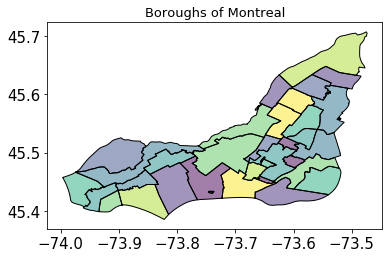

In [53]:
# optional plot of mtl boroughs
import geopandas as gpd
mtlbr = gpd.read_file('../geo/limadmin-shp/LIMADMIN.shp')
plt.figure(figsize=(10,15))
mtlbr.plot()
plt.title("Boroughs of Montreal")

In [54]:
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)
plt.rc('legend', fontsize=13)
plt.rc('figure', titlesize=25)
plt.rc('axes', titlesize=13)
member_color = 'darkorange'
casual_color = 'royalblue'
all_color = 'darkcyan'

In [55]:
# load data from saved files - map take a while
blocs, weather, weather_code_names, bdata = utils.load_default()

Loading station infromation from saved file
Loading weather from saved file
Loading bikes with weather from saved file


In [56]:
# set datetime for use later
bdata['start_dt'] = pd.to_datetime(bdata['start_date'])
bdata['end_dt'] = pd.to_datetime(bdata['end_date'])

In [57]:
# determine how popular a borough is
mtlbr['num_stations'] = 0
mtlbr['start_events_member'] = 0
mtlbr['end_events_member'] = 0
mtlbr['start_events_casual'] = 0
mtlbr['end_events_casual'] = 0
pps = gpd.GeoSeries([Point(pt) for pt in zip(blocs['longitude'], blocs['latitude'])])
for nbr_idx in mtlbr.index:
    mtlbr.loc[nbr_idx,'num_stations'] = np.sum(blocs['neighborhood code']==nbr_idx)
    mtlbr.loc[nbr_idx,'start_events_member'] = np.sum(blocs.loc[blocs['neighborhood code']==nbr_idx, 'start_events_member'])
    mtlbr.loc[nbr_idx,'end_events_member'] = np.sum(blocs.loc[blocs['neighborhood code']==nbr_idx, 'end_events_member'])
    mtlbr.loc[nbr_idx,'start_events_casual'] = np.sum(blocs.loc[blocs['neighborhood code']==nbr_idx, 'start_events_casual'])
    mtlbr.loc[nbr_idx,'end_events_casual'] = np.sum(blocs.loc[blocs['neighborhood code']==nbr_idx, 'end_events_casual'])

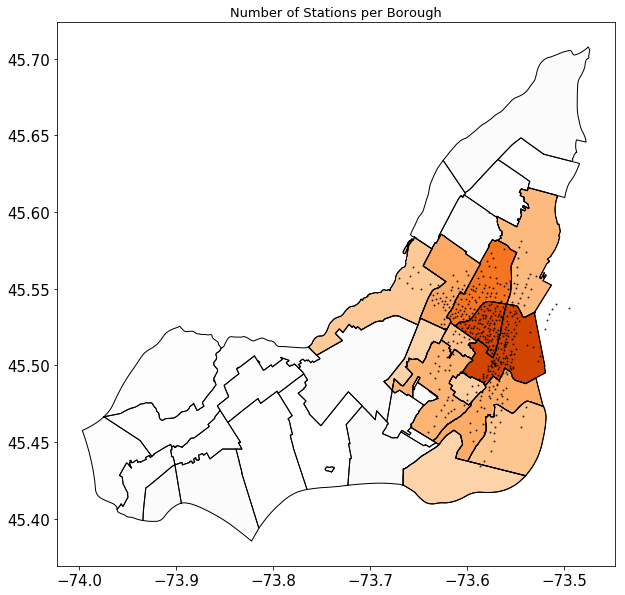

In [58]:
# plot stations per borough
fig, ax = plt.subplots(figsize=(10,10))
mtloc = mtlbr[mtlbr['num_stations']>0]
mtlbr.plot(ax=ax, cmap=plt.cm.binary)
vmax = mtloc['num_stations'].max()+50
vmin = mtloc['num_stations'].min()-50
# hacky way to make color look right
mtloc.plot(ax=ax, column='num_stations', vmin=vmin, vmax=vmax, alpha=1, cmap=plt.cm.Oranges)
pps.plot(ax=ax, color='k', alpha=.71, markersize=1)
ax.set_title("Number of Stations per Borough")

In [59]:
# find out which boroughs are popular
mtloc.loc[:,'casual_events'] = mtloc['start_events_casual'] + mtloc['end_events_casual']
mtloc.loc[:,'member_events'] = mtloc['start_events_member'] + mtloc['end_events_member']
mtloc.loc[:,'casual_events_norm'] = np.array(mtloc['casual_events'])/float(np.sum(mtloc['casual_events']))
mtloc.loc[:,'member_events_norm'] = np.array(mtloc['member_events'])/float(np.sum(mtloc['member_events']))

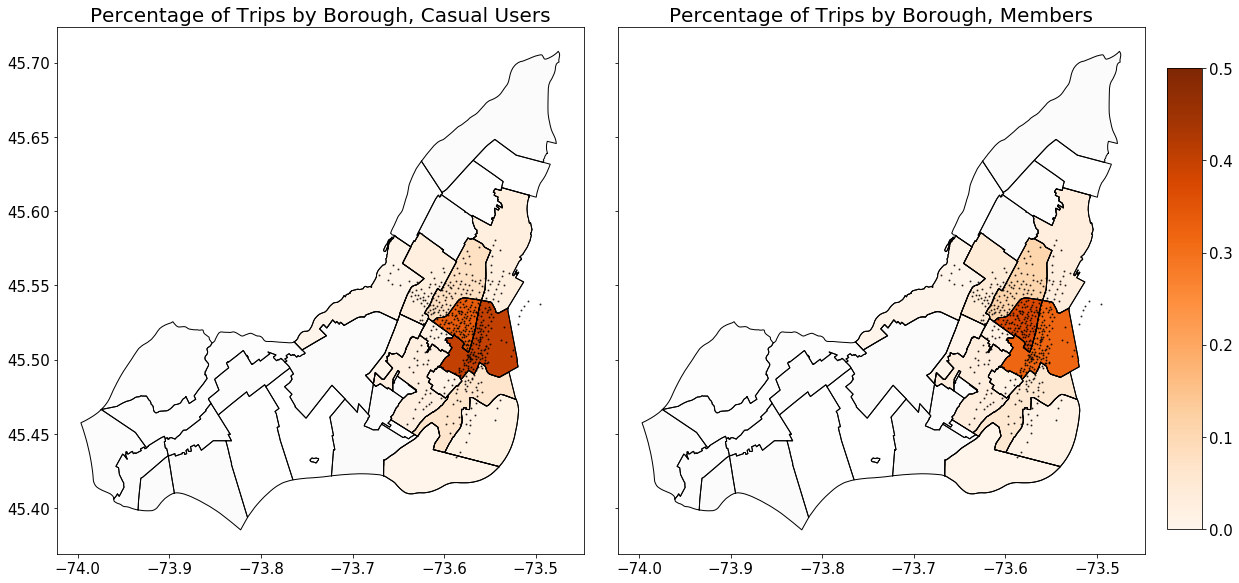

In [60]:
fig, ax = plt.subplots(1,2,sharey=True,figsize=(16,8))
fig.tight_layout()
vmax = .5
vmin = 0
# hacky way to make color look right
mtlbr.plot(ax=ax[0], cmap=plt.cm.binary)
mtloc.plot(ax=ax[0], column='casual_events_norm', vmin=vmin, vmax=vmax, alpha=1, cmap=plt.cm.Oranges)
pps.plot(ax=ax[0], color='k', alpha=.71, markersize=1)
ax[0].set_title("Percentage of Trips by Borough, Casual Users", fontsize=20)

mtlbr.plot(ax=ax[1], cmap=plt.cm.binary)
mtloc.plot(ax=ax[1], column='member_events_norm', vmin=vmin, vmax=vmax, alpha=1, cmap=plt.cm.Oranges)
pps.plot(ax=ax[1], color='k', alpha=.71, markersize=1)
ax[1].set_title("Percentage of Trips by Borough, Members", fontsize=20)

# add colorbar
fig = ax[1].get_figure()
cax = fig.add_axes([1, 0.1, 0.03, 0.8])
sm = plt.cm.ScalarMappable(cmap=plt.cm.Oranges, norm=plt.Normalize(vmin=vmin, vmax=vmax))
# fake up the array of the scalar mappable. Urgh...
sm._A = []
fig.colorbar(sm, cax=cax)

In [61]:
# stations which are on the islands
jdrap_island = [6109, 6501, 6504, 6259, 6509]
start_island = bdata[bdata['start_station_code'].isin(jdrap_island)]
ends_on_island = bdata['end_station_code'].isin(jdrap_island)
end_island = bdata[ends_on_island]
island = start_island[ends_on_island]
perc_island_cas = island.shape[0]-np.sum(island['is_member'])

/Users/jhansen/anaconda/envs/bike/lib/python2.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


In [62]:
start_low = bdata.loc[bdata.loc[:,'start_station_elev']<10,:]
end_high = start_low.loc[start_low.loc[:,'end_station_elev']>110,:]
#end_high[:,'duration_min']
end_high['duration_min']

2193339    65.7
Name: duration_min, dtype: float64

In [63]:
start_high= bdata.loc[bdata.loc[:,'start_station_elev']>110,:]
end_low = start_high.loc[start_high.loc[:,'end_station_elev']<10,:]
#end_high[:,'duration_min']
end_low['duration_min'].max()

95.849999999999994

In [64]:
# determine how many bikes leave each station
most_start = bdata['start_station_code'].value_counts()
# determine how many bikes are racked at each station
most_end = bdata['end_station_code'].value_counts()
# add both together so we can pick stations which are popular
most_both = most_start+most_end
most_both = most_both.sort_values(axis=0, ascending=False)
blocs.index = blocs['code']

blocs['events'] = most_both
ismem = bdata.loc[:,'is_member']>0
bdatamem = bdata[ismem]
bdatacas = bdata[~ismem]
# determine how many bikes leave each station
most_start_mem = bdatamem['start_station_code'].value_counts()
# determine how many bikes are racked at each station
most_end_mem = bdatamem['end_station_code'].value_counts()
# determine how many bikes leave each station
most_start_cas = bdatacas['start_station_code'].value_counts()
# determine how many bikes are racked at each station
most_end_cas = bdatacas['end_station_code'].value_counts()
blocs['start events cas'] = most_start_cas
blocs['end events cas'] = most_end_cas
blocs['start events mem'] = most_start_mem
blocs['end events mem'] = most_end_mem

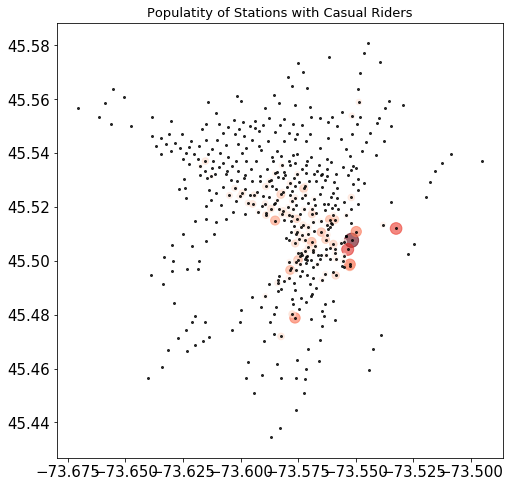

In [65]:
# most popular tourist areas
fig, ax = plt.subplots(figsize=(8,8))
blocs['events_casual'] = blocs['start_events_casual']+blocs['end_events_casual']
casual_pop = blocs.sort_values('events_casual', ascending=False)
casual_pop = casual_pop.iloc[:casual_pop.shape[0]-360,:]

plt.scatter(casual_pop['longitude'], casual_pop['latitude'], 
            s=casual_pop['events_casual']*.005,  c=casual_pop['events_casual'], cmap=plt.cm.Reds, marker='o', alpha=.6)
plt.scatter(blocs['longitude'], blocs['latitude'], c='k', s=4, alpha=.8)

plt.title("Populatity of Stations with Casual Riders")


In [66]:
casual_pop.shape

(105, 24)

In [67]:
# determine what percentage of trips are roundtrip
rts = bdata[bdata['start_station_code'] == bdata['end_station_code']]
memrts = rts['is_member']==1
pmemrts = np.sum(memrts)/float(bdatamem.shape[0])
pcasrts = (rts.shape[0]-np.sum(memrts))/float(bdatacas.shape[0])
print('perc rt', pmemrts, pcasrts)

('perc rt', 0.013928387043257237, 0.049673195817322442)


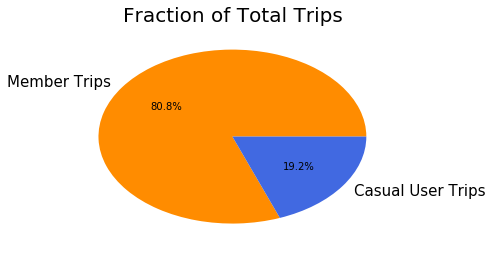

In [68]:
per_mem = np.sum(ismem)/float(bdata.shape[0])*100
labels = ['Member Trips', 'Casual User Trips']
fracs = [per_mem, 100-per_mem]
s=plt.pie(fracs, labels=labels, autopct='%1.1f%%', colors=[member_color, casual_color])
plt.title("Fraction of Total Trips", fontsize=20)

In [69]:
def calculate_fees(v, init_fee_begins=45):
    """
    init_fee_begins is time that fee starts (45 for members, 30 for non-members
    )"""
    init_fee = 1.75
    recur_fee = 3
    # init [first overage at min, first overage fee]
    # recurring [recurring fee starts at min, recurring overage is]
    fee = 0
    # calculate initial fee
    i = v[v>init_fee_begins]
    
    fee+=i.shape[0]*init_fee
    #print("INIT", v.shape[0], i.shape[0], fee)
    r = deepcopy(i)
    
    for ur in range(init_fee_begins+15, int(r.max()+15), 15):
        r = r[r>ur]
        fee+=r.shape[0]*recur_fee
        
    return i.shape[0], fee

mem_ovr, mem_tot_fee = calculate_fees(bdatamem['duration_min'], 45)
cas_ovr, cas_tot_fee = calculate_fees(bdatacas['duration_min'], 30)
tot_fees = mem_tot_fee+cas_tot_fee

(0.005348810144322851, 0.15740938138594093)


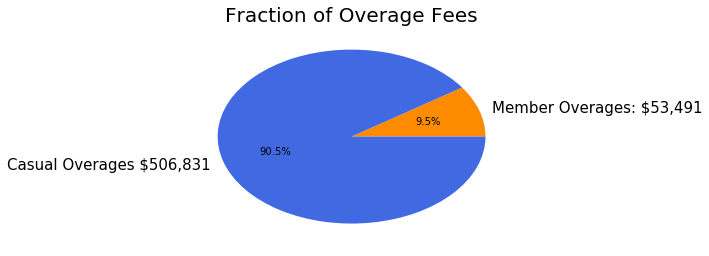

In [70]:
mem_tot_fee_fmt = locale.format('%d',mem_tot_fee, grouping=True)
cas_tot_fee_fmt = locale.format('%d',cas_tot_fee, grouping=True)

ovr_labels = ['Member Overages: $%s' %mem_tot_fee_fmt, 
              'Casual Overages $%s' %cas_tot_fee_fmt]
ovr_fracs = [mem_tot_fee/tot_fees, cas_tot_fee/tot_fees]
s=plt.pie(ovr_fracs, labels=ovr_labels, autopct='%1.1f%%', colors=[member_color, casual_color])
plt.title("Fraction of Overage Fees", fontsize=20)
print(mem_ovr/float(bdatamem.shape[0]), cas_ovr/float(bdatacas.shape[0]))

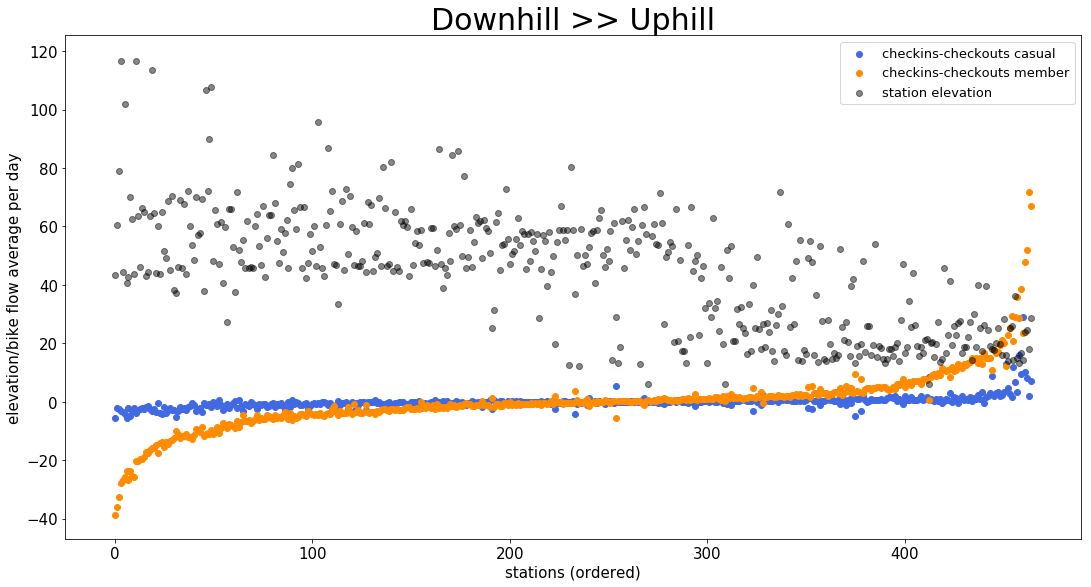

In [71]:
# Am I the only lazy one who finds it impossible to take a bixi uphill?
blocs.sort_values(axis=0, by='events', inplace=True, ascending=False)
total_days = float(bdata['day of year'].unique().shape[0])
stati = blocs.index
# approximate daily
start_e = np.array(blocs['start_events'])/total_days
end_e = np.array(blocs['end_events'])/total_days
stat_names = blocs['name fmt']

stat_r = np.arange(start_e.shape[0])
diff = end_e-start_e
diff_sorted = sorted(zip(stati, diff, stat_names), key=lambda group: group[1])
diff_sorted_code = [d[0] for d in diff_sorted]
diff_sorted_val = np.array([d[1] for d in diff_sorted])
diff_sorted_name = [d[2] for d in diff_sorted]

start_cas = np.array(blocs.loc[np.array(diff_sorted_code), 'start events cas'])/total_days
end_cas = np.array(blocs.loc[np.array(diff_sorted_code), 'end events cas'])/total_days
diff_cas = end_cas-start_cas
start_mem = np.array(blocs.loc[np.array(diff_sorted_code), 'start events mem'])/total_days
end_mem = np.array(blocs.loc[np.array(diff_sorted_code), 'end events mem'])/total_days
diff_mem = end_mem-start_mem

dis_name = np.array(blocs.loc[diff_sorted_code,'name fmt'])
dis_elev = blocs.loc[diff_sorted_code,'elev']
f, ax = plt.subplots(figsize=(15,8))
#plt.scatter(stat_r, diff_sorted_val, label='checkins-checkouts', c=all_color)
plt.scatter(stat_r, diff_cas, label='checkins-checkouts casual', c=casual_color)
plt.scatter(stat_r, diff_mem, label='checkins-checkouts member', c=member_color)
plt.scatter(stat_r, dis_elev, label='station elevation', c='k', alpha=.47)
#plt.scatter(stat_r, dis_dt, label='distance to dt', c='k', alpha=.17)
plt.legend()
ax.set_title("Downhill >> Uphill", fontsize=30)
plt.tight_layout()
plt.ylabel('elevation/bike flow average per day', fontsize=15)
plt.xlabel('stations (ordered)', fontsize=15)


#ss = plt.xticks(np.arange(0, blocs.shape[0], 50), rotation=70)
#labels = ax.get_xticks().tolist()
#olabels = [diff_sorted_name[int(x)] for x in labels]
#sq = ax.set_xticklabels(olabels)

In [72]:
s_drap = bdata['start_station_code']==6501
e_jb = bdata['end_station_code']==6316
dr_jb = np.argmax((s_drap & e_jb))
#bdata.loc[dr_jb,:]

In [73]:
# trips taken by members
percentage_trip_member = bdatamem.shape[0]/float(bdata.shape[0])
time_member = bdatamem['duration_min'].mean()
time_casual = bdatacas['duration_min'].mean()
time_all = bdata['duration_min'].mean()
overflow_member = sum(bdatamem['duration_min']>45)/float(bdatamem.shape[0])
overflow_casual = sum(bdatacas['duration_min']>45)/float(bdatacas.shape[0])
overflow_all = sum(bdata['duration_min']>45)/float(bdata.shape[0])

In [74]:
# downhill vs uphill
diffmem = bdatamem['start_station_elev']-bdatamem['end_station_elev']
mdownhill = np.sum(diffmem>-5)/float(diffmem.shape[0])
print('mem downhill', mdownhill)
muphill = np.sum(diffmem<-40)/float(diffmem.shape[0])
print('mem uphill', muphill)
diffcas = bdatacas['start_station_elev']-bdatacas['end_station_elev']
cdownhill = np.sum(diffcas>-5)/float(diffcas.shape[0])
print('cas downhill', cdownhill)
cuphill = np.sum(diffcas<-40)/float(diffcas.shape[0])
print('cas uphill', cuphill)

('mem downhill', 0.74397922256076798)
('mem uphill', 0.011173352086100955)
('cas downhill', 0.71169085416265854)
('cas uphill', 0.015540747827805134)


In [75]:
np.sum(bdatacas['start_station_elev']-bdatacas['end_station_elev']>-10)/float(bdatacas.shape[0])

0.78875372431974289

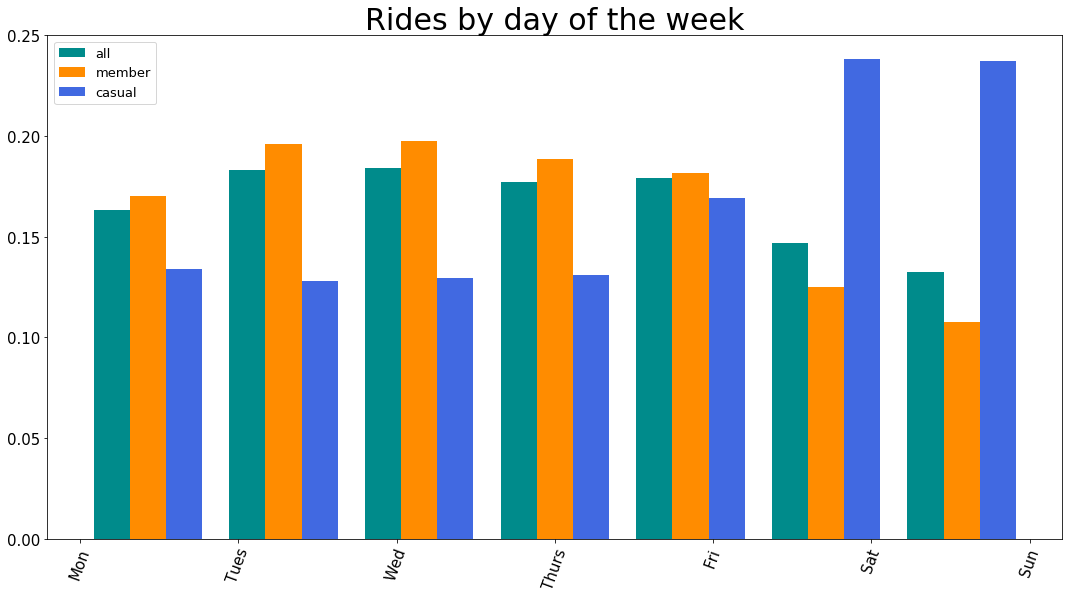

In [76]:
hdata = [bdata['weekday'],
         bdatamem['weekday'],
         bdatacas['weekday']]
colors = [all_color, member_color, casual_color]
f, ax = plt.subplots(figsize=(15,8))
plt.hist(hdata, 7, stacked=False, histtype='bar', normed=True, color=colors, label=['all', 'member', 'casual'])
plt.legend()
ax.set_title("Rides by day of the week", fontsize=30)
plt.tight_layout()
ss = plt.xticks(range(7), rotation=70)
dlabels = ['Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun']
sq = ax.set_xticklabels(dlabels)

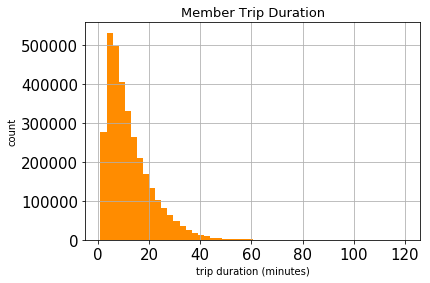

In [77]:
bdatamem.hist(column='duration_min', bins=50, color=member_color)
plt.title("Member Trip Duration")
plt.ylabel("count")
plt.xlabel("trip duration (minutes)")

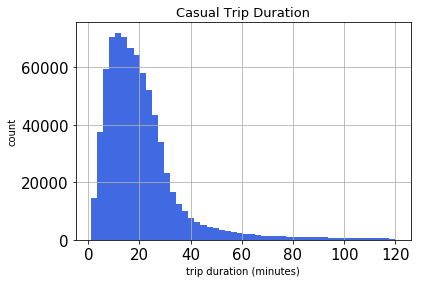

In [78]:
bdatacas.hist(column='duration_min', bins=50, color=casual_color)
plt.title("Casual Trip Duration")
plt.ylabel("count")
plt.xlabel("trip duration (minutes)")

In [79]:
# plot heatmap of trips
plt.figure(figsize=(10,10))
plt.scatter(np.array(blocs['longitude']),  np.array(blocs["latitude"]),
            c=blocs['events'], edgecolor='face', alpha=.8,  s=40, )    
plt.axis('tight')
mplleaflet.display()

In [80]:
# get weather information
wcolors = ['gold', 'c', 'slategray', 'darkslateblue']
mweath_indx = [int(i) for i in sorted(bdata['Weather Code'].unique())]
mweath_names = [weather_code_names[i] for i in mweath_indx] 
mweaths = [bdata[bdata.loc[:,'Weather Code']==xx] for xx in mweath_indx]
print(mweath_names)

['Clear/Cloudy', 'Drizzle/Fog', 'Rain', 'Snow']


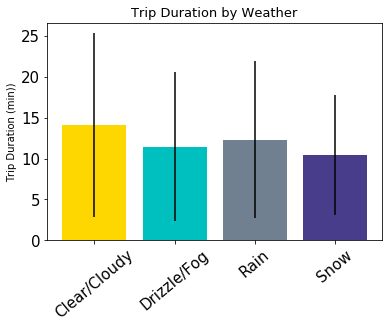

In [81]:
mw_means = [xx['duration_min'].mean() for xx in mweaths]
mw_stds = [xx['duration_min'].std() for xx in mweaths]

plt.bar(range(len(mw_means)), mw_means, 
        yerr=mw_stds, color=wcolors)
r=plt.xticks(range(len(mweath_names)), mweath_names, rotation=40)
plt.ylabel("Trip Duration (min))")
plt.title("Trip Duration by Weather")

In [82]:
mweaths[2].columns

Index([u'Unnamed: 0', u'start_date', u'start_station_code', u'end_date',
       u'end_station_code', u'duration_sec', u'is_member', u'filename_x',
       u'orig index', u'all index', u'duration_min', u'dt_x', u'weekday',
       u'year', u'date', u'hour', u'time', u'day of year', u'isweekday',
       u'instance', u'isholiday', u'start_lat', u'start_lon', u'end_lat',
       u'end_lon', u'end_station_name', u'start_station_name',
       u'start_station_elev', u'end_station_elev', u'elev change',
       u'start hour', u'start datehour', u'end hour', u'Unnamed: 0.1', u'dt_y',
       u'Year', u'Month', u'Day', u'Time', u'Data Quality', u'Temp',
       u'Temp Flag', u'Dew Point Temp (C)', u'Dew Point Temp Flag',
       u'Rel Hum (%)', u'Rel Hum Flag', u'Wind Dir (10s deg)',
       u'Wind Dir Flag', u'Wind Spd (km/h)', u'Wind Spd Flag',
       u'Visibility (km)', u'Visibility Flag', u'Stn Press (kPa)',
       u'Stn Press Flag', u'Hmdx', u'Hmdx Flag', u'Wind Chill',
       u'Wind Chill Flag', u

In [83]:
def find_corresponding_stations(ddf):    
    starts = list(ddf['start_station_code'].unique())
    ends = list(ddf['end_station_code'].unique())
    start_end_dur = pd.DataFrame(index=starts, columns=ends, dtype=np.float16)
    end_start_dur = pd.DataFrame(index=ends, columns=starts) 
    start_end_cnt = pd.DataFrame(index=starts, columns=ends)
    end_start_cnt = pd.DataFrame(index=ends, columns=starts) 
    for sstat in starts:
        sdf = ddf[ddf.loc[:,'start_station_code']==sstat]
        endss = list(sdf['end_station_code'].unique())
        for estat in endss:
            adf = sdf[sdf.loc[:,'end_station_code']==estat]
            start_end_dur.loc[sstat,estat] = adf['duration_min'].mean()
            start_end_cnt.loc[sstat,estat] = adf['instance'].sum()
  
    return start_end_dur.fillna(0), start_end_cnt.fillna(0)

weather_durs_cnts = [find_corresponding_stations(w) for w in mweaths]

In [84]:
mweaths[0].columns

Index([u'Unnamed: 0', u'start_date', u'start_station_code', u'end_date',
       u'end_station_code', u'duration_sec', u'is_member', u'filename_x',
       u'orig index', u'all index', u'duration_min', u'dt_x', u'weekday',
       u'year', u'date', u'hour', u'time', u'day of year', u'isweekday',
       u'instance', u'isholiday', u'start_lat', u'start_lon', u'end_lat',
       u'end_lon', u'end_station_name', u'start_station_name',
       u'start_station_elev', u'end_station_elev', u'elev change',
       u'start hour', u'start datehour', u'end hour', u'Unnamed: 0.1', u'dt_y',
       u'Year', u'Month', u'Day', u'Time', u'Data Quality', u'Temp',
       u'Temp Flag', u'Dew Point Temp (C)', u'Dew Point Temp Flag',
       u'Rel Hum (%)', u'Rel Hum Flag', u'Wind Dir (10s deg)',
       u'Wind Dir Flag', u'Wind Spd (km/h)', u'Wind Spd Flag',
       u'Visibility (km)', u'Visibility Flag', u'Stn Press (kPa)',
       u'Stn Press Flag', u'Hmdx', u'Hmdx Flag', u'Wind Chill',
       u'Wind Chill Flag', u

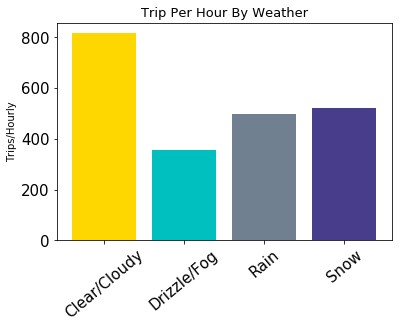

In [85]:
mw_cnt_m = [a[1].sum().sum() for a in weather_durs_cnts]
mw_hrs = [a['start datehour'].unique().shape[0] for a in mweaths]
tot_rides = [a/float(b) for a,b in zip(mw_cnt_m, mw_hrs)]

plt.bar(range(len(tot_rides)), tot_rides, 
         color=wcolors)
r=plt.xticks(range(len(mweath_names)), mweath_names, rotation=40)
plt.ylabel("Trips/Hourly")
plt.title("Trip Per Hour By Weather")

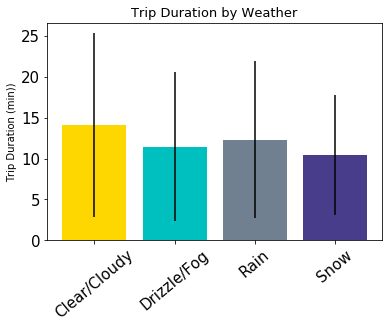

In [86]:
mw_means = [xx['duration_min'].mean() for xx in mweaths]
mw_stds = [xx['duration_min'].std() for xx in mweaths]

plt.bar(range(len(mw_means)), mw_means, 
        yerr=mw_stds, color=wcolors)
r=plt.xticks(range(len(mweath_names)), mweath_names, rotation=40)
plt.ylabel("Trip Duration (min))")
plt.title("Trip Duration by Weather")

In [87]:
count_daily = bdata['instance'].groupby(bdata['date']).sum()
mem_daily = bdata['is_member'].groupby(bdata['date']).sum()
cas_daily = count_daily-mem_daily
weather_daily = bdata['Weather Code'].groupby(bdata['date']).max()
weekend = ~bdata['isweekday'].groupby(bdata['date']).max()
t_daily = bdata['Temp'].groupby(bdata['date']).mean()
daily = pd.DataFrame({'count':count_daily, 'Weather Code':weather_daily, 
                      'Temp':t_daily, 'Members':mem_daily, 'Casuals':cas_daily, 'Weekend':weekend})


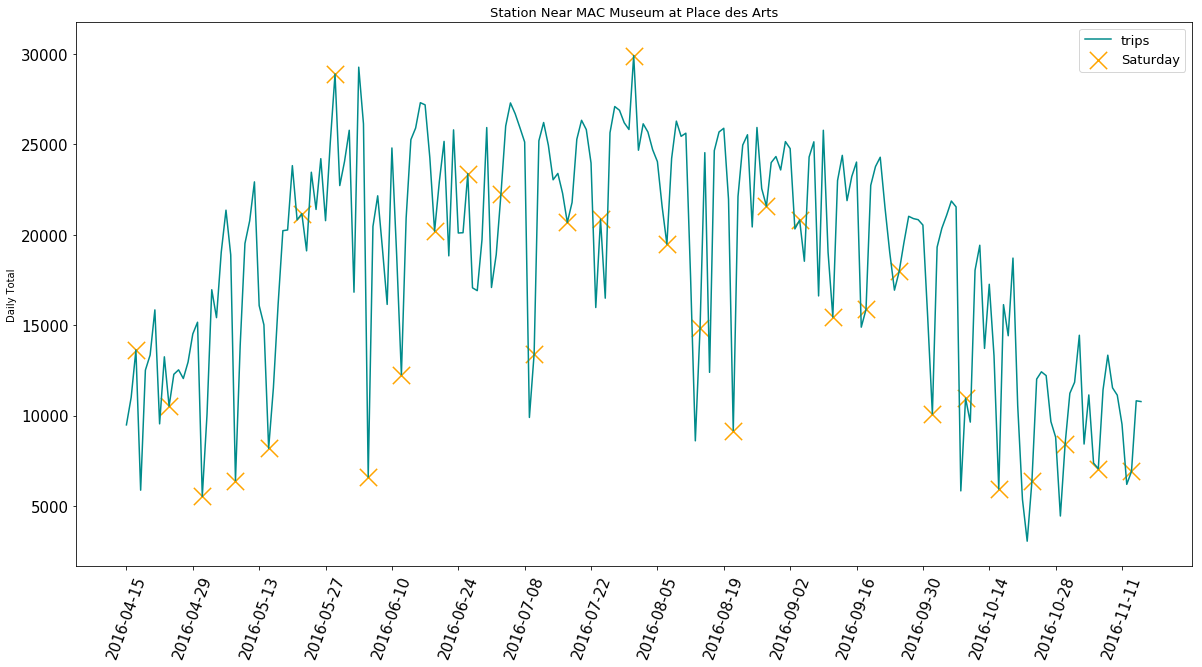

In [88]:
# mus day 
mus = bdata[bdata.loc[:,'end_station_code']==6078]
mus_daily = bdata[['is_member', 'instance']].groupby(bdata['date']).sum()
mus_daily['weekday'] = bdata['weekday'].groupby(bdata['date']).max()

weekends = np.array(np.where(mus_daily['weekday']==6)[0])

nn = np.arange(0,mus_daily.shape[0])
iis = np.array(mus_daily['instance'])

zz = weekends
wk = iis[zz]

xxs = range(0, nn.shape[0], 14)
f, ax = plt.subplots(figsize=(20,10))
plt.plot(nn, iis, c=all_color, label='trips')
plt.scatter(zz,wk, marker='x', c='orange', s=300, label="Saturday")
ss = plt.xticks(xxs, rotation=70)
dlabels = [list(mus_daily.index)[xx] for xx in xxs]
sq = ax.set_xticklabels(dlabels)
plt.legend()
plt.ylabel("Daily Total")
plt.title("Station Near MAC Museum at Place des Arts")

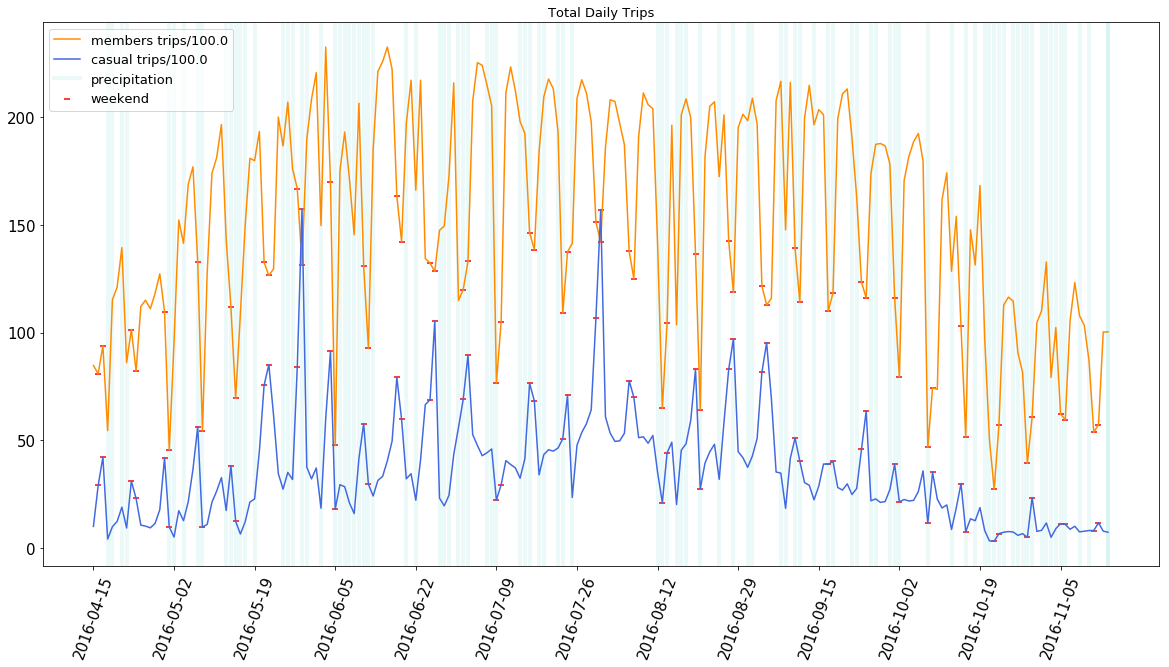

In [89]:
f, ax = plt.subplots(figsize=(20,10))
nn = np.arange(0,daily.shape[0])
ddiv = 100.0
mems = np.array(daily['Members']/ddiv)
cass = np.array(daily['Casuals']/ddiv)
weekends = np.array(daily['Weekend'])
zz = np.where(weekends>0)
zm = mems[zz]
zc = cass[zz]
rainy = np.array(daily['Weather Code']>1)
wz = list(np.where(rainy>0)[0])
xposition = list(wz)
for xc in xposition:
    plt.axvline(x=xc, color='c', linestyle='-', linewidth=4, alpha=.08)

#plt.scatter(nn, daily['Temp'], c='k', alpha=.8, s=9,label='temperature')
plt.plot(nn, mems, c=member_color, label='members trips/%s' %ddiv)
plt.plot(nn, cass, c=casual_color, label='casual trips/%s' %ddiv)
plt.scatter(zz, zm, c='r', marker='_', label='weekend')
plt.scatter(zz, zc, c='r', marker='_',)
plt.axvline(x=xc, color='c', linestyle='-', linewidth=4, alpha=.08, label='precipitation')
xxs = range(0, nn.shape[0], 17)
ss = plt.xticks(xxs, rotation=70)
dlabels = [list(daily.index)[xx] for xx in xxs]
sq = ax.set_xticklabels(dlabels)
plt.legend()
plt.title("Total Daily Trips")

In [90]:
# find the hourly checkin/checkouts by station
stations_hrly = {}
stations = {}
start = bdata.loc[0,'start_dt']
end = bdata.loc[bdata.shape[0]-1,'end_dt']
start = start.floor('1H')
end = end.ceil('1H')
stations_hourly = pd.DataFrame()
station_code_key = np.array(blocs.index)
stations_avg_checkins = np.zeros((blocs.shape[0], 24))
stations_avg_checkouts = np.zeros((blocs.shape[0], 24))
stations_tot_checkins = np.zeros((blocs.shape[0], 24))
stations_tot_checkouts = np.zeros((blocs.shape[0], 24))
for xxx, station in enumerate(list(blocs.index)):
    this_station_st = bdata[bdata['start_station_code'] == station]
    this_station_en = bdata[bdata['end_station_code'] == station]
    stations[station] = {'checkout':deepcopy(this_station_st), 
                         'checkin':deepcopy(this_station_en)}
    this_station_st.index = this_station_st['start_dt']
    this_station_en.index = this_station_en['end_dt']
    
    checkins = this_station_st['instance'].resample('1H').sum()
    checkouts = this_station_en['instance'].resample('1H').sum()
    
    tweather = this_station_st['Weather Code'].resample('1H').last().ffill()
    weatherfill = this_station_st['Weather Fill'].resample('1H').last().ffill()
    temp = this_station_st['Temp'].resample('1H').mean().ffill()
    
    hourly = pd.DataFrame(index=pd.date_range(start, end, freq='1H'), columns={'checkins', 'checkouts'})
    hourly['checkins'] = checkins
    hourly['checkouts'] = checkouts
    hourly['Weather Code'] = tweather
    hourly['Weather Fill'] = weatherfill
    hourly['Temp'] = temp
    hourly['hour'] = hourly.index.hour
    
    stations_tot_checkouts[xxx,:] = np.array(hourly.groupby('hour')['checkouts'].sum())
    stations_tot_checkins[xxx,:] = np.array(hourly.groupby('hour')['checkins'].sum())
    stations_avg_checkouts[xxx,:] = np.array(hourly.groupby('hour')['checkouts'].mean())
    stations_avg_checkins[xxx,:] = np.array(hourly.groupby('hour')['checkins'].mean()) 
    stations_hrly[station] = hourly
# remove nan
stations_avg_checkouts[np.isnan(stations_avg_checkouts)] = 0
stations_avg_checkins[np.isnan(stations_avg_checkins)] = 0
stations_tot_checkouts[np.isnan(stations_tot_checkouts)] = 0
stations_tot_checkins[np.isnan(stations_tot_checkins)] = 0


In [98]:

    
def plot_over_time(param0,  param1):
    fig, (ax0,ax1) = plt.subplots(1,2, sharey=True, figsize=(20,10))
    nn = mpl.colors.Normalize()
    m0 = mpl.cm.ScalarMappable(norm=nn, cmap=plt.cm.Greens)
    m1 = mpl.cm.ScalarMappable(norm=nn, cmap=plt.cm.Reds)
    i = 0
    def scale_s( ch):
        ss1 = (ch-ch.min())/(
              ch.max()-ch.min())
        print('bmin', ch.min(), ch.max())
        ss1 = ss1*1500
        ss1[ss1>350] = 350
        ss1[ss1<150] = 150
        return ss1

    ss0 = scale_s(param0)
    ss1 = scale_s(param1)
    dd0 = ax0.scatter(blocs['longitude'], blocs['latitude'], 
                     facecolor=m0.to_rgba(param0[:,0]+10), 
                     edgecolor="None", 
                     s=ss0,
                     alpha=.7, marker='.', )
    
    dd1 = ax1.scatter(blocs['longitude'], blocs['latitude'], 
                     facecolor=m1.to_rgba(param1[:,0]+10), 
                     edgecolor="None", 
                     s=ss0,
                     alpha=.7, marker='.', )

    
    ttl = fig.suptitle("Station Popularity by Hour: 00-01 H" )
    ax0.set_title("Checkouts")
    ax1.set_title("Checkins")
    
    def mapinit():
        return dd0,dd1,
    
    

    def mapanimate(i):
        o = int(i) + 0 
        ttl.set_text("Station Popularity by Hour: %02d-%02d H" %(o,o+1))
        #"Relative Station Popularity by Hour: 00-01 H"
        x0 = m0.to_rgba(param0[:,o]+10)
        
        dd0.set_facecolor(x0)
        
        x1 = m1.to_rgba(param1[:,o]+10)
        
        dd1.set_facecolor(x1)
        return dd0,dd1,

    # call the animator.  blit=True means only re-draw the parts that have changed.
    anim = animation.FuncAnimation(fig, mapanimate, init_func=mapinit,
                                   frames=24, interval=100, blit=True)

    # call our new function to display the animation
    return display_animation(anim)
plot_over_time( stations_avg_checkouts, stations_avg_checkins)


('bmin', 0.0, 47.214285714285715)
('bmin', 0.0, 31.363207547169811)


In [99]:

    
def plot_relative_over_time(param0,  param1):
    fig, (ax0,ax1) = plt.subplots(1,2, sharey=True, figsize=(20,10))
    nn = mpl.colors.Normalize()
    m0 = mpl.cm.ScalarMappable(norm=nn, cmap=plt.cm.Greens)
    m1 = mpl.cm.ScalarMappable(norm=nn, cmap=plt.cm.Reds)
    i = 0
    def scale_s( ch):
        ss1 = (ch-ch.min())/(
              ch.max()-ch.min())
        print('bmin', ch.min(), ch.max())
        ss1 = ss1*1500
        ss1[ss1>350] = 350
        ss1[ss1<150] = 150
        return ss1

    ss0 = scale_s(param0)
    ss1 = scale_s(param1)
    dd0 = ax0.scatter(blocs['longitude'], blocs['latitude'], 
                     facecolor=m0.to_rgba(param0[:,0]+10), 
                     edgecolor="None", 
                     s=ss0,
                     alpha=.7, marker='.', )
    
    dd1 = ax1.scatter(blocs['longitude'], blocs['latitude'], 
                     facecolor=m1.to_rgba(param1[:,0]+10), 
                     edgecolor="None", 
                     s=ss0,
                     alpha=.7, marker='.', )

    
    ttl = fig.suptitle("Relative Station Popularity by Hour: 00-01 H" )
    ax0.set_title("Checkouts")
    ax1.set_title("Checkins")
    def mapinit():
        
        return dd0,dd1
    
    

    def mapanimate(i):
        o = int(i) + 0 
        ttl.set_text("Relative Station Popularity by Hour: %02d-%02d H" %(o,o+1))
        #"Relative Station Popularity by Hour: 00-01 H"
        x = m0.to_rgba(param0[:,o]+10)
        xx0 = (x - x.min()) / (x.max() - x.min())
        dd0.set_facecolor(xx0)
        
        x = m1.to_rgba(param1[:,o]+10)
        xx1 = (x - x.min()) / (x.max() - x.min())
        dd1.set_facecolor(xx1)
        return dd0,dd1,

    # call the animator.  blit=True means only re-draw the parts that have changed.
    anim = animation.FuncAnimation(fig, mapanimate, init_func=mapinit,
                                   frames=24, interval=100, blit=True)

    # call our new function to display the animation
    return display_animation(anim)
plot_relative_over_time( stations_avg_checkouts, stations_avg_checkins)


('bmin', 0.0, 47.214285714285715)
('bmin', 0.0, 31.363207547169811)


In [104]:
def create_hourly_dataset(df, station=6221):
    print("Creating hourly dataset for station: %s" %station)
    sstat = df[df.loc[:,'start_station_code']==station]
    estat = df[df.loc[:,'end_station_code']==station]
    sstat.index = sstat['start_date']
    estat.index = estat['end_date']
    
    start_count = sstat.resample("1H")['start_date'].count()
    end_count = estat.resample("1H")['end_date'].count()
    events = (start_count==0) + (end_count==0)
    events = events.fillna(value=1)
    
    ws = sstat['Weather Code'].resample("1H").last().ffill()
    wf = sstat['Weather Fill'].resample("1H").last().ffill()
    hol = sstat['isholiday'].resample("1H").last().ffill()
    wd = sstat['weekday'].resample("1H").last().ffill()
    ts = sstat['Temp'].resample("1H").last()
    tss = ts.interpolate(method='linear')
    num_nans = np.sum(np.isnan(np.array(tss)))
    h = pd.concat([ws, hol, tss, wf, wd, start_count, end_count], axis=1)
    
    h['start_date'] = h['start_date'].fillna(value=0)
    h['end_date'] = h['end_date'].fillna(value=0)
    h.loc[:,'Temp'] = h['Temp'].fillna(method='ffill')
    h.loc[:,'Temp'] = h['Temp'].fillna(method='bfill')

    h.loc[:,'Weather Code'] = h['Weather Code'].bfill()
    h.loc[:,'Weather Fill'] = h['Weather Fill'].bfill()
    h.loc[:,'weekday'] = h['weekday'].bfill()
    h.loc[:,'weekday'] = h['weekday'].ffill()
    h.loc[:,'Weather Code'] = h['Weather Code'].ffill()
    h.loc[:,'Weather Fill'] = h['Weather Fill'].ffill()
    
    h.loc[:,'sum count'] = h['start_date'] - h['end_date']
    h['hour'] = h.index.hour
    h['minute'] = h.index.minute
    h['year'] = h.index.year
    h['date'] = h.index.date

    h['day of year'] = h.index.dayofyear
    h['day of week'] = h.index.dayofweek
    h['date'] = pd.to_datetime(h.index)
    num_nans = np.sum(np.isnan(np.array(h['Temp'])))
    num_hols = np.sum((np.array(h['Temp'])))
    
    arrivals = []
    departures = []
    for ii in range(24):
        sthis_hour = start_count.index.hour == ii
        departure = np.sum(start_count[sthis_hour])
        
        ethis_hour = end_count.index.hour == ii
        arrival = np.sum(end_count[ethis_hour])

        arrivals.append(arrival)
        departures.append(departure)

    return h, arrivals, departures, sstat, estat



In [105]:

def make_cyclic(x, max_cycle):
    max_cycle = float(max_cycle)
    c = (x % max_cycle)/max_cycle * 2.0 * np.pi
    return np.sin(c), np.cos(c)

def create_X(hourly):
    wf = np.array(hourly['Weather Code'])
    ss = list(set(wf))
    
    wcn = [weather_code_names[int(xx)] for xx in ss]
    wfoh = np.zeros((wf.shape[0], len(ss)))
    for xx, s in enumerate(ss):
        wfoh[wf==s,xx] = 1
    
    t1,t2 = make_cyclic(np.array(hourly['hour'])+np.array(hourly['minute'])/60.,24)
    y1,y2 = make_cyclic(hourly['day of year'], 365.)
    w1,w2 = make_cyclic(hourly['day of week'], 7.)

    nn = t1.shape[0]
    aX = np.array(hourly[[ 'Temp']])

    aX_scaled  = preprocessing.scale(aX)
    X = np.concatenate(( t1[:,None],t2[:,None], aX_scaled,
                        w1[:,None],w2[:,None], y1[:,None], y2[:,None],
                         wfoh,
                       ),axis=1)
    labels = ['time1', 'time2', 'Temp', 'day wk1',  'day wk2', 'day year1', 'day year2']+wcn
    return X, labels

def create_model(hourly, station_code):
    rf = RandomForestClassifier(n_estimators=100, random_state=10)
    
    X, labels = create_X(hourly)
    y = np.array(hourly['sum count'])
    y_choice = list(set(y))
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.15,  random_state=10)
    
    o = rf.fit(X_train,y_train)
    rf.score(X_train,y_train)
   
    y_pred = rf.predict(X)
    y_test_pred = rf.predict(X_test)

    yerr =  mean_squared_error(y, y_pred)
    ytesterr = mean_squared_error(y_test,y_test_pred)
    
    return X, y, rf, labels
